In [1]:
import numpy as np
import os
import pandas as pd
sys.path.append(os.path.abspath("C:/Users/mieke/Documents/Msc Thesis/Notebooks Python/Final/"))
import functions_model #import python file containing the functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
#import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, mean_squared_error
import geopandas as gpd
import warnings
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import random
import math

random.seed(1234) # Set random seed

c:\Users\mieke\anaconda3\envs\thesis_base\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For updates
import importlib
importlib.reload(functions_model)

<module 'functions_model' from 'c:\\Users\\mieke\\Documents\\Msc Thesis\\Notebooks Python\\Final\\functions_model.py'>

In [3]:
# Importing the data
dataset = gpd.read_file(r'D:\other_thesis\rf_params.geojson') 

In [4]:
data = dataset[dataset['Average Yield(Kg/Ha)'] != 0] # Throw away average yield values of zero

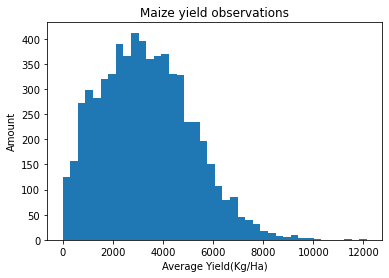

In [5]:
# Let us start with plotting all datapoints for maize
avg_value = np.mean(dataset['Average Yield(Kg/Ha)']) # 3331 kg/ha
median_value = np.median(dataset['Average Yield(Kg/Ha)']) # 3208 kg/ha  

plt.hist(dataset['Average Yield(Kg/Ha)'], bins = 40)
plt.title('Maize yield observations')
plt.xlabel('Average Yield(Kg/Ha)')
plt.ylabel('Amount')
plt.show()

In [6]:
data['Year'] = pd.to_datetime(data['Year'], format = '%Y') # Change Year column to datetime type
# NOTE: This dataset is already sorted wrt time, i.e., year 2016-2017-2018 and rabi-summer-kharif


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
train = data[data['Year']<'2018'].reset_index() # For now, we use 2016-2017 as training data
test = data[data['Year']>='2018'].reset_index() # For now, we use 2018 as test data
print('Length training and test data, respectively:', len(train), len(test))

Length training and test data, respectively: 4412 1918


In [8]:
data.columns # Shows all features within my dataframe
feature_list = ['NDVI_avg', 'NDVI_max', 'EVI_avg', 'EVI_max', 'FAPAR_avg', 'FAPAR_max', 'LAI_avg', 'LAI_max', 'SIF_avg', 'SIF_max', 'SSM_med', 'SSM_max', 'SUSM_med', 'SUSM_max', 'LST_med', 'LST_max', 'LSTN_med', 'LSTN_max', 'Prec_acc', 'Prec_non', 'Irrigated', 'Kharif', 'Soil_I', 'Soil_Vp', 'Soil_WR', 'Soil_Bv', 'Soil_Ne', 'Soil_Vc', 'Soil_Ap', 'Soil_Lc']

In [9]:
#Set Random Forest Regression Model
rf = RandomForestRegressor()

# Number of trees in random forest
n_estimators = np.arange(200, 2000, 200).tolist()
# Number of features to consider at every split
max_features = ['auto', int(len(feature_list)/3)]
# Maximum number of levels in tree
max_depth = np.arange(10, 40, 2).tolist()
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Set number of folds
k = 4

#Time Series Cross Validation 
btscv = functions_model.BlockingTimeSeriesSplit(n_splits=k)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1000, cv = btscv, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(train[feature_list], train['Average Yield(Kg/Ha)'])

rf_random.best_params_

# OUTCOMES
# {'n_estimators': 600,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 10,
#  'max_depth': 12,
#  'bootstrap': True}

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': 12,
 'bootstrap': True}

In [10]:
# Create the parameter grid based on the results of random search (see last comment)
param_grid = {
    'n_estimators': np.arange(400, 800, 20).tolist(),
    'min_samples_split': [3,4,5,6,7,8],
    'min_samples_leaf': [1,2,3],
    'max_features': [int(len(feature_list)/3)],
    'max_depth': [10, 11, 12, 13, 14], 
    'bootstrap': [True], 
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = btscv, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(train[feature_list], train['Average Yield(Kg/Ha)'])

hyperparameters = grid_search.best_params_

print(hyperparameters)
# {'bootstrap': True, 'max_depth': 13, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 460}

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


{'bootstrap': True, 'max_depth': 13, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 460}


In [11]:
# Set parameters for the Random Forest Regression based on the outcomes from the Grid Search
max_depth_ = hyperparameters['max_depth']
bootstrap_ = hyperparameters['bootstrap']
n_estimators_ = hyperparameters['n_estimators']
max_features_ = hyperparameters['max_features']
min_samples_leaf_ = hyperparameters['min_samples_leaf']
min_samples_split_ = hyperparameters['min_samples_split']
k_fold = k

In [17]:
for md in range(1,max_depth_+1):
    print(md)
#max_depth_

1
2
3
4
5
6
7
8
9
10
11
12
13


In [20]:
#Investigate every subset of explanatory variables
parameter_scores = []
i=0
for features_com in functions_model.subsets(feature_list):
    for md in [5,8,9,10,11,12,max_depth_]:
        for n_est in [n_estimators_, 1300]:

            array_X = np.array(data[features_com])
            array_Y = np.array(data['Average Yield(Kg/Ha)'])

            cv = functions_model.BlockingTimeSeriesSplit(n_splits = k_fold)

            for train_index, test_index in cv.split(array_X):
                MAE_folds = []
                EF_folds = []
                R2_folds = []
                RMSE_folds = []
                MAPE_folds =[]
                accuracy_folds = []
                
                #print('TRAIN:', train_index, 'TEST', test_index) 
                x_train, x_test = array_X[train_index], array_X[test_index]
                y_train, y_test = array_Y[train_index], array_Y[test_index]

                max_features_optimal = int(len(features_com)/3)
                if max_features_optimal == 0:
                    max_features_optimal = 1

                clf = RandomForestRegressor(n_estimators = n_est, max_depth = md, bootstrap = bootstrap_, max_features = max_features_, min_samples_leaf = min_samples_leaf_, min_samples_split = min_samples_split_)

                #Fit to the training data
                clf.fit(x_train, y_train)

                #Make a prediction on the test data
                predictions = clf.predict(x_test)

                #Calculate mean absolute error
                MAE_folds.append(mean_absolute_error(y_test, predictions))
            
                #MAPE
                errors = abs(predictions - y_test)
                mape = 100 * (errors / y_test)

                # Calculate and display accuracy
                accuracy_folds.append(100 - np.mean(mape))

                #RMSE
                MSE_folds = np.square(np.subtract(y_test, predictions)).mean() # mean_squared_error(y_test, predictions)
                RMSE_folds.append(math.sqrt(MSE_folds)) # math.sqrt(mean_squared_error(y_test, predictions))

                #R2
                R2_folds.append(r2_score(y_test, predictions))

                # EF
                EF_folds.append(1 - sum(np.square(y_test - predictions)) / sum(np.square(y_test - np.mean(y_test))))
            

            EF = sum(EF_folds)/len(EF_folds)
            MAE = sum(MAE_folds)/len(MAE_folds)
            RMSE = sum(RMSE_folds)/len(RMSE_folds)
            R2 = sum(R2_folds)/len(R2_folds)
            Accuracy = sum(accuracy_folds)/len(accuracy_folds)
            parameter_scores.append((MAE, RMSE, EF, R2, Accuracy, md, n_est, features_com))
    i += 1        
    print(i, ' done.')        

1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.
10  done.
11  done.
12  done.
13  done.
14  done.
15  done.
16  done.
